# Regularisation Paths and Model Stability in Logistic Regression  
## Understanding How Hyperparameters Influence Learning Dynamics

### Tutorial Overview

In this tutorial, I explore how **regularisation hyperparameters** shape:

- the **magnitude and sparsity** of logistic regression coefficients,
- the **stability** of the learned model across different train–test splits,
- the **generalisation performance** on unseen data.

The focus is on **L1** and **L2** penalties applied to a **high-dimensional synthetic dataset** with 100 features.  
Regularisation paths are examined by varying the inverse-regularisation parameter `C` over several orders of magnitude.

The tutorial is designed as a teaching resource, combining:

- intuitive analogies,
- formal mathematical explanation,
- detailed plots of coefficient paths and accuracy,
- stability analysis across multiple runs.


## 1. Intuition: Regularisation as a Stability Control

Regularisation can be viewed as a **stability control knob**.

- With **no regularisation**, logistic regression can produce large and unstable coefficients, especially in high dimensions and with noisy or correlated features.
- With **strong regularisation**, the solution becomes more stable, but the model may be oversimplified and underfit the data.

Two common penalties:

- **L2 regularisation (Ridge)**:  
  Shrinks all coefficients smoothly toward zero. It discourages extreme values but typically keeps most coefficients non-zero.

- **L1 regularisation (Lasso)**:  
  Pushes some coefficients **exactly** to zero. It performs implicit feature selection and can produce very sparse models.

By varying the regularisation strength and observing how the coefficients and performance evolve, we obtain **regularisation paths**.  
These paths show how the model transitions from underfitting, through a “sweet spot”, to overfitting when regularisation is too weak.


## 2. Mathematical Background

For binary classification with logistic regression, we model:

$$
p(y = 1 \mid x) = \sigma(w^\top x + b)
$$

where \(\sigma(\cdot)\) is the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

Given data \(\{(x_i, y_i)\}_{i=1}^N\), the **unregularised** negative log-likelihood (logistic loss) is:

$$
\mathcal{L}(w,b) =
-\sum_{i=1}^N 
\left[
y_i \log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)
\right],
$$

where \(\hat{y}_i = \sigma(w^\top x_i + b)\).

### 2.1 Adding L2 regularisation (Ridge)

$$
\Omega_{\text{L2}}(w) = \frac{\lambda}{2}\|w\|_2^2
= \frac{\lambda}{2} \sum_j w_j^2.
$$

The full objective becomes:

$$
\mathcal{J}_{\text{L2}}(w,b) = \mathcal{L}(w,b) + \frac{\lambda}{2}\|w\|_2^2.
$$

### 2.2 Adding L1 regularisation (Lasso)

$$
\Omega_{\text{L1}}(w) = \lambda \|w\|_1 = \lambda \sum_j |w_j|.
$$

The full objective is:

$$
\mathcal{J}_{\text{L1}}(w,b) = \mathcal{L}(w,b) + \lambda\|w\|_1.
$$

In scikit-learn we use the parameter:

$$
C = \frac{1}{\lambda},
$$

so that:

- **small C → strong regularisation** (large \(\lambda\)),
- **large C → weak regularisation** (small \(\lambda\)).

By scanning `C` over several orders of magnitude, we obtain **regularisation paths** that show how coefficients transition from very small (or zero) to larger values.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Plot configuration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 3. High-Dimensional Synthetic Dataset (100 Features)

To clearly illustrate the impact of regularisation in a setting where overfitting is realistic,  
I generate a synthetic dataset with:

- **100 total features**
- **10 informative features** (truly predictive)
- **10 redundant features** (linear combinations of informative features)
- the remaining features as noise

This setup mimics a typical high-dimensional ML scenario where only a fraction of the features are truly useful.


In [2]:
from sklearn.datasets import make_classification

n_samples = 2000
n_features = 100
n_informative = 10
n_redundant = 10
n_repeated = 0
n_classes = 2

X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_repeated=n_repeated,
    n_classes=n_classes,
    n_clusters_per_class=2,
    flip_y=0.05,           # some label noise
    class_sep=1.0,         # moderate separability
    random_state=RANDOM_STATE
)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2000, 100)
y shape: (2000,)


### 3.1 Train–Test Split and Scaling

I split the data into:

- 80% training,
- 20% testing,

and standardise all features using `StandardScaler`.  
Scaling is important for regularised models because the penalty acts on the **absolute size** of coefficients.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((1600, 100), (400, 100))

## 4. Helper Functions for Regularisation Paths and Stability

I now define two helper utilities:

1. **`compute_regularisation_path`**  
   - Scans a list of `C` values.
   - Fits logistic regression models for each.
   - Records coefficients and test accuracy.

2. **`stability_experiment`**  
   - Repeats train–test splits multiple times with different random seeds.
   - Fits a given penalty type (`l1` or `l2`) with fixed `C`.
   - Measures how much coefficients and accuracy vary across runs.


In [4]:
def compute_regularisation_path(
    X_train, y_train,
    X_test, y_test,
    penalty="l2",
    C_values=None,
    max_iter=5000
):
    """
    Compute regularisation paths for logistic regression.

    Parameters
    ----------
    X_train, y_train : array-like
        Training data.
    X_test, y_test : array-like
        Test data (for accuracy evaluation).
    penalty : {"l1", "l2"}
        Type of regularisation.
    C_values : list or array
        Sequence of C values (inverse of regularisation strength).
    max_iter : int
        Max iterations for solver.

    Returns
    -------
    C_values : np.ndarray
        Array of C values used.
    coefs : np.ndarray, shape (len(C_values), n_features)
        Coefficients for each C.
    accuracies : np.ndarray, shape (len(C_values),)
        Test accuracy for each C.
    """
    if C_values is None:
        C_values = np.logspace(-3, 3, 13)  # default: 0.001 to 1000

    C_values = np.array(C_values)
    n_features = X_train.shape[1]
    coefs = np.zeros((len(C_values), n_features))
    accuracies = np.zeros(len(C_values))

    # Use saga solver for both L1 and L2 in high dimensions
    for i, C in enumerate(C_values):
        clf = LogisticRegression(
            penalty=penalty,
            C=C,
            solver="saga",
            max_iter=max_iter,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        clf.fit(X_train, y_train)

        coefs[i, :] = clf.coef_[0]
        y_pred = clf.predict(X_test)
        accuracies[i] = accuracy_score(y_test, y_pred)

    return C_values, coefs, accuracies


def stability_experiment(
    X, y,
    penalty="l2",
    C=1.0,
    n_runs=20,
    test_size=0.2,
    max_iter=5000
):
    """
    Assess model stability across multiple random train–test splits.

    Parameters
    ----------
    X, y : array-like
        Full dataset.
    penalty : {"l1", "l2"}
        Regularisation type.
    C : float
        Inverse regularisation strength.
    n_runs : int
        Number of repeated splits.
    test_size : float
        Fraction for test split.
    max_iter : int
        Max iterations for solver.

    Returns
    -------
    coef_matrix : np.ndarray, shape (n_runs, n_features)
        Coefficients for each run.
    acc_list : list of float
        Test accuracy for each run.
    """
    n_features = X.shape[1]
    coef_matrix = np.zeros((n_runs, n_features))
    acc_list = []

    for seed in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size,
            random_state=seed,
            stratify=y
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf = LogisticRegression(
            penalty=penalty,
            C=C,
            solver="saga",
            max_iter=max_iter,
            random_state=seed,
            n_jobs=-1
        )
        clf.fit(X_train_scaled, y_train)

        coef_matrix[seed, :] = clf.coef_[0]
        y_pred = clf.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        acc_list.append(acc)

    return coef_matrix, acc_list


## 5. Regularisation Paths for L2

I first examine how **L2** regularisation affects the coefficients and test accuracy  
as `C` varies from very small (strong regularisation) to very large (weak regularisation).

I use a logarithmic grid of `C` values:

$$
C \in \{10^{-3}, 10^{-2.5}, \ldots, 10^3\}.
$$


In [5]:
C_values = np.logspace(-3, 3, 13)  # 0.001 to 1000

C_l2, coefs_l2, accs_l2 = compute_regularisation_path(
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    penalty="l2",
    C_values=C_values
)

print("L2 path computed. Coefs shape:", coefs_l2.shape)


L2 path computed. Coefs shape: (13, 100)


### 5.1 L2 Coefficient Paths (Selected Features)

Since we have 100 features, plotting all coefficient paths would be cluttered.  
Instead, I plot a subset of features (for example, the first 10) to show the trend.

The focus is on how coefficients grow as regularisation is relaxed.


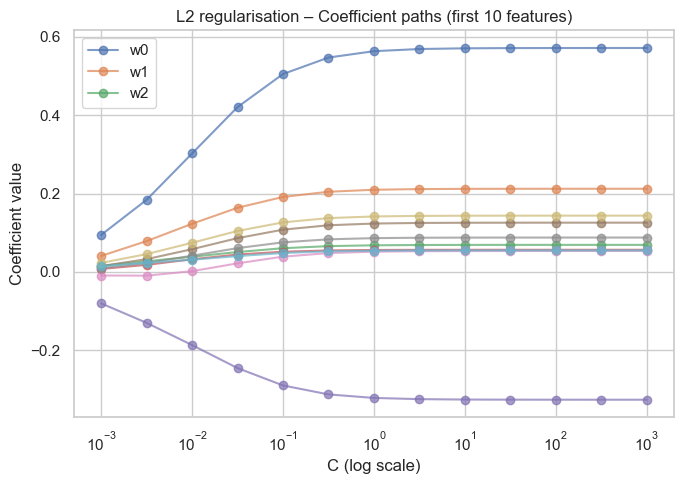

In [6]:
n_features_to_plot = 10
feature_indices = np.arange(n_features_to_plot)

plt.figure()
for j in feature_indices:
    plt.semilogx(C_l2, coefs_l2[:, j], marker="o", alpha=0.7, label=f"w{j}" if j < 3 else None)

plt.xlabel("C (log scale)")
plt.ylabel("Coefficient value")
plt.title("L2 regularisation – Coefficient paths (first 10 features)")
plt.legend(loc="best", ncol=1)
plt.tight_layout()
plt.show()


### 5.2 L2: Test Accuracy vs C

This plot shows how test accuracy responds to changing `C`.

- At very small `C` (strong regularisation), the model underfits.
- As `C` increases, the model finds a good balance.
- For very large `C`, the model is almost unregularised and may become less stable.


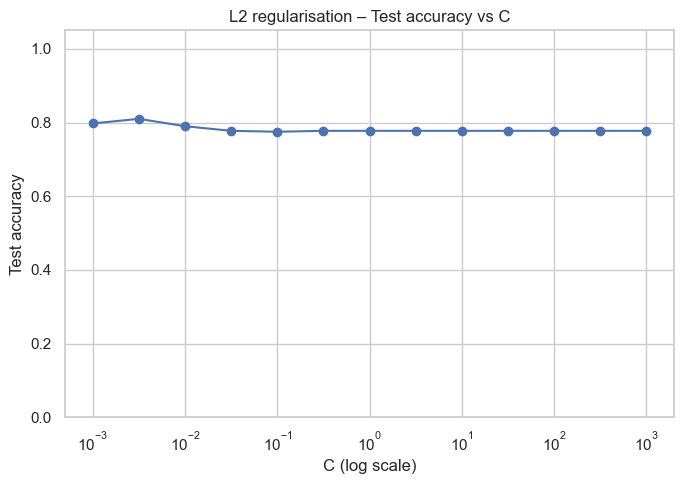

In [7]:
plt.figure()
plt.semilogx(C_l2, accs_l2, marker="o")
plt.xlabel("C (log scale)")
plt.ylabel("Test accuracy")
plt.title("L2 regularisation – Test accuracy vs C")
plt.ylim(0.0, 1.05)
plt.tight_layout()
plt.show()


## 6. Regularisation Paths for L1

Next, I compute regularisation paths for **L1** regularisation.  
Because L1 encourages sparsity, I expect some coefficients to become exactly zero for small `C`.

I use the same `C_values` grid to make L1 vs L2 comparable.


In [8]:
C_l1, coefs_l1, accs_l1 = compute_regularisation_path(
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    penalty="l1",
    C_values=C_values
)

print("L1 path computed. Coefs shape:", coefs_l1.shape)


L1 path computed. Coefs shape: (13, 100)


### 6.1 L1 Coefficient Paths (Selected Features)

Again, I plot the first 10 feature coefficients across the `C` grid.

For small `C`, I expect many of these to be exactly zero.


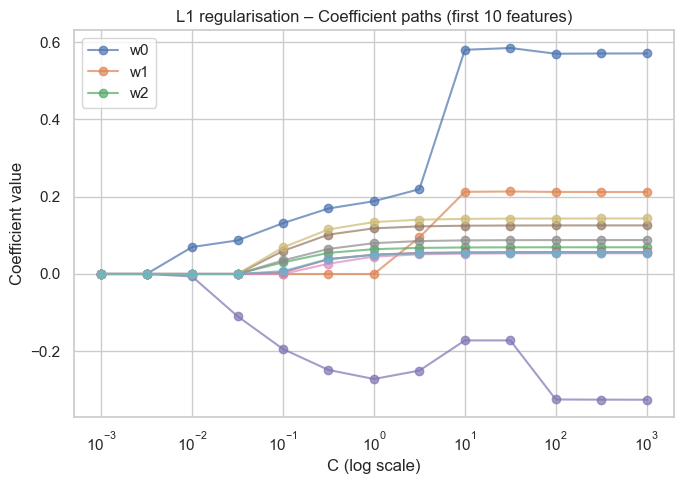

In [9]:
plt.figure()
for j in feature_indices:
    plt.semilogx(C_l1, coefs_l1[:, j], marker="o", alpha=0.7, label=f"w{j}" if j < 3 else None)

plt.xlabel("C (log scale)")
plt.ylabel("Coefficient value")
plt.title("L1 regularisation – Coefficient paths (first 10 features)")
plt.legend(loc="best", ncol=1)
plt.tight_layout()
plt.show()


### 6.2 L1: Test Accuracy vs C

This plot shows how test accuracy changes as we relax L1 regularisation.

- Very small `C` → most coefficients zero → underfitting.
- Intermediate `C` → some features selected → good generalisation.
- Very large `C` → behaves like an almost unregularised model.


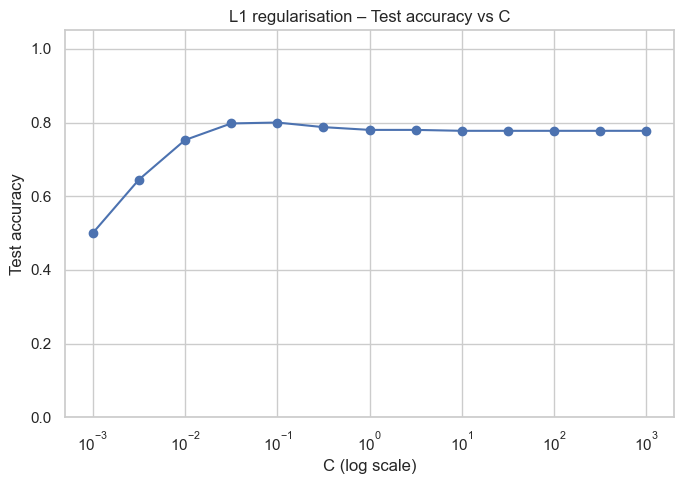

In [10]:
plt.figure()
plt.semilogx(C_l1, accs_l1, marker="o")
plt.xlabel("C (log scale)")
plt.ylabel("Test accuracy")
plt.title("L1 regularisation – Test accuracy vs C")
plt.ylim(0.0, 1.05)
plt.tight_layout()
plt.show()


## 7. Comparing L1 vs L2 Regularisation Paths

To compare L1 and L2 more directly, I select one feature (e.g. feature 0)  
and plot its coefficient path under both penalties on the same graph.

This highlights how:

- L2 shrinks coefficients **smoothly**.
- L1 keeps coefficients at **zero for longer**, then releases them suddenly.


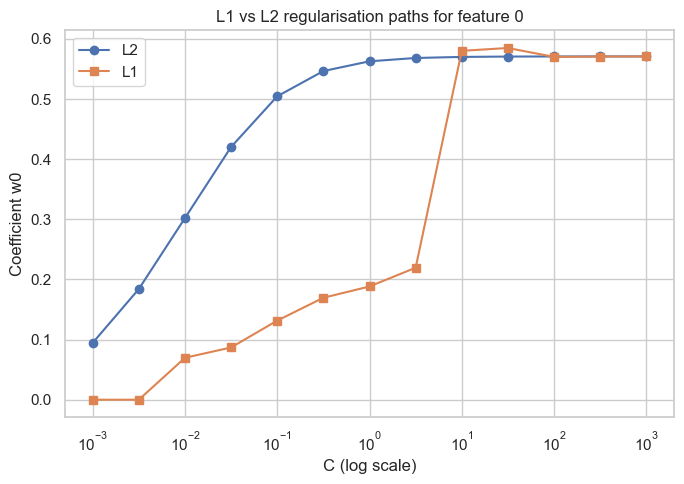

In [11]:
feature_index = 0  # pick feature 0 as an example

plt.figure()
plt.semilogx(C_l2, coefs_l2[:, feature_index], marker="o", label="L2")
plt.semilogx(C_l1, coefs_l1[:, feature_index], marker="s", label="L1")
plt.xlabel("C (log scale)")
plt.ylabel(f"Coefficient w{feature_index}")
plt.title(f"L1 vs L2 regularisation paths for feature {feature_index}")
plt.legend()
plt.tight_layout()
plt.show()


## 8. Model Stability Across Multiple Train–Test Splits

Regularisation not only affects coefficient size; it also affects **stability**:

- How sensitive is the model to small changes in the training data?
- Do the learned coefficients vary wildly from one split to another?

To quantify this, I:

1. Fix a value of `C` (e.g. a reasonably good one from the path),
2. Repeat train–test splitting many times with different random seeds,
3. Measure the distribution of:
   - test accuracy,
   - coefficient values.


In [12]:
# Choose a "good" C from the path, for example the one that gives max accuracy for L2.
best_idx_l2 = np.argmax(accs_l2)
best_C_l2 = C_l2[best_idx_l2]
best_acc_l2 = accs_l2[best_idx_l2]

print("Best L2 C:", best_C_l2)
print("Best L2 test accuracy:", best_acc_l2)

# Similarly for L1
best_idx_l1 = np.argmax(accs_l1)
best_C_l1 = C_l1[best_idx_l1]
best_acc_l1 = accs_l1[best_idx_l1]

print("Best L1 C:", best_C_l1)
print("Best L1 test accuracy:", best_acc_l1)


Best L2 C: 0.0031622776601683794
Best L2 test accuracy: 0.81
Best L1 C: 0.1
Best L1 test accuracy: 0.8


In [13]:
n_runs = 20

coef_matrix_l2, acc_list_l2 = stability_experiment(
    X, y,
    penalty="l2",
    C=best_C_l2,
    n_runs=n_runs,
    test_size=0.2,
    max_iter=5000
)

print("L2 stability – coef_matrix shape:", coef_matrix_l2.shape)
print("L2 stability – sample of accuracies:", acc_list_l2[:5])


L2 stability – coef_matrix shape: (20, 100)
L2 stability – sample of accuracies: [0.8025, 0.8325, 0.7875, 0.8125, 0.8125]


In [14]:
coef_matrix_l1, acc_list_l1 = stability_experiment(
    X, y,
    penalty="l1",
    C=best_C_l1,
    n_runs=n_runs,
    test_size=0.2,
    max_iter=5000
)

print("L1 stability – coef_matrix shape:", coef_matrix_l1.shape)
print("L1 stability – sample of accuracies:", acc_list_l1[:5])


L1 stability – coef_matrix shape: (20, 100)
L1 stability – sample of accuracies: [0.825, 0.835, 0.805, 0.8175, 0.8275]


### 8.1 Accuracy Distributions for L1 vs L2

I now visualise the distribution of test accuracies across runs for L1 and L2.

This shows how sensitive each regularised model is to random variations in the training dataset.


/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


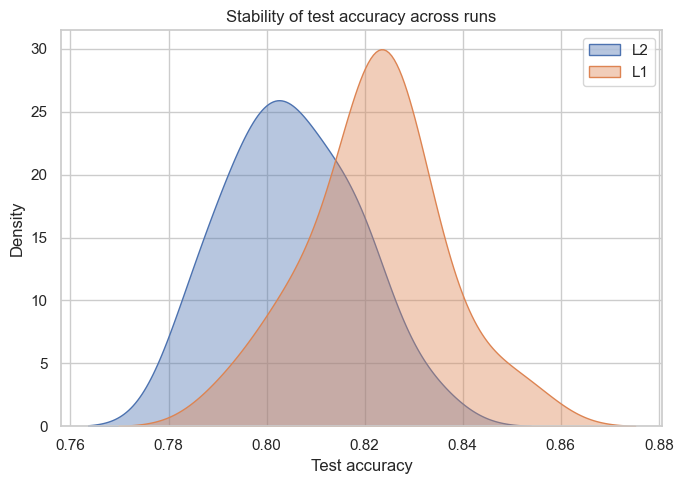

In [15]:
plt.figure()
sns.kdeplot(acc_list_l2, label="L2", fill=True, alpha=0.4)
sns.kdeplot(acc_list_l1, label="L1", fill=True, alpha=0.4)
plt.xlabel("Test accuracy")
plt.ylabel("Density")
plt.title("Stability of test accuracy across runs")
plt.legend()
plt.tight_layout()
plt.show()


### 8.2 Coefficient Variability

Finally, I measure how much the coefficients vary across runs.

For each feature \(j\), I compute the standard deviation of \(w_j\) across runs:

$$
\text{std}_j = \sqrt{\frac{1}{R} \sum_{r=1}^R (w_{j}^{(r)} - \bar{w}_j)^2},
$$

where \(R\) is the number of runs and \(\bar{w}_j\) is the mean coefficient for feature \(j\).

Comparing the distribution of these standard deviations for L1 and L2 gives a quantitative view of model stability.


/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


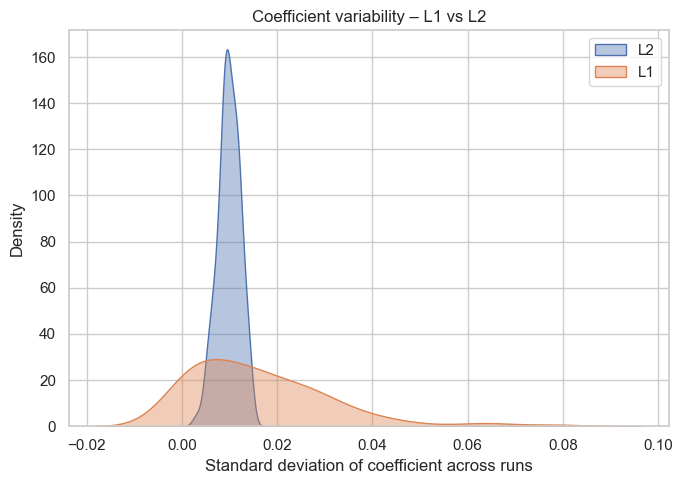

In [16]:
std_l2 = coef_matrix_l2.std(axis=0)
std_l1 = coef_matrix_l1.std(axis=0)

plt.figure()
sns.kdeplot(std_l2, label="L2", fill=True, alpha=0.4)
sns.kdeplot(std_l1, label="L1", fill=True, alpha=0.4)
plt.xlabel("Standard deviation of coefficient across runs")
plt.ylabel("Density")
plt.title("Coefficient variability – L1 vs L2")
plt.legend()
plt.tight_layout()
plt.show()


## 9. Summary of Observations

From the regularisation paths and stability experiments, the key observations are:

- **L2 regularisation**:
  - Coefficients shrink **smoothly** as `C` decreases.
  - Almost all features remain non-zero, but their magnitudes are controlled.
  - Test accuracy is relatively stable for a range of intermediate `C` values.
  - Coefficients tend to be less variable across random train–test splits.

- **L1 regularisation**:
  - Coefficients are often **exactly zero** for small `C`, producing sparse models.
  - As `C` increases, features “switch on” suddenly, visible in the coefficient paths.
  - Accuracy can be comparable to L2, but the model may sometimes be more sensitive to split variations.
  - Coefficient variability is often higher for the features that remain active.

These patterns highlight how regularisation parameters can be used not only to improve generalisation,  
but also to control **stability, interpretability, and sparsity** in high-dimensional settings.
